In [1]:
import sys
sys.path.append('/Applications/Stata/utilities/')
from pystata import config
config.init('be')


  ___  ____  ____  ____  ____ ®
 /__    /   ____/   /   ____/      17.0
___/   /   /___/   /   /___/       BE—Basic Edition

 Statistics and Data Science       Copyright 1985-2021 StataCorp LLC
                                   StataCorp
                                   4905 Lakeway Drive
                                   College Station, Texas 77845 USA
                                   800-STATA-PC        https://www.stata.com
                                   979-696-4600        stata@stata.com

Stata license: Unlimited-user, expiring  7 Feb 2024
Serial number: 401709311377
  Licensed to: Charlie Zhang
               Georgetown University

Notes:
      1. Unicode is supported; see help unicode_advice.


In [2]:
# import sys
# sys.path.append('/Applications/Stata/utilities/')
# from pystata import config
# config.init('be')

import os
os.chdir("../")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
%%stata
ssc install schemepack, replace

checking schemepack consistency and verifying not already installed...
all files already exist and are up to date.


In [4]:
%%stata 
clear all 
global folder "/Users/czhang/Desktop/pacific-observatory" 

** Save the palau_merged as tempfile for merging
import delimited using "$folder/data/tourism/palau/intermediate/palau_merged.csv", 
generate time = m(2019m1) + _n-1 
format time %tm 
tempfile merged 
save `merged'

** Merge with the Covid Stringency Index
import delimited using "$folder/data/tourism/oceania_covid_stringency.csv", clear
merge 1:1 date using `merged'
keep if _merge == 2 | _merge == 3


. clear all 

. global folder "/Users/czhang/Desktop/pacific-observatory" 

. 
. ** Save the palau_merged as tempfile for merging
. import delimited using "$folder/data/tourism/palau/intermediate/palau_merged.
> csv", 
(encoding automatically selected: ISO-8859-1)
(16 vars, 45 obs)

. generate time = m(2019m1) + _n-1 

. format time %tm 

. tempfile merged 

. save `merged'
file /var/folders/kn/jw0y9v615mjgg3_51g3s73zh0000gn/T//St22666.000002 saved
    as .dta format

. 
. ** Merge with the Covid Stringency Index
. import delimited using "$folder/data/tourism/oceania_covid_stringency.csv", c
> lear
(encoding automatically selected: ISO-8859-1)
(5 vars, 38 obs)

. merge 1:1 date using `merged'

    Result                      Number of obs
    -----------------------------------------
    Not matched                            17
        from master                         5  (_merge==1)
        from using                         12  (_merge==2)

    Matched                            

In [5]:
%%stata
// Drop the _merge variables
drop _merge v1 
replace stringency_index = 0 if stringency_index == . 
tsset time 

// Generate Covid variable 
gen covid = . 
replace covid = 1 if date >= "2020m3"


. // Drop the _merge variables
. drop _merge v1 

. replace stringency_index = 0 if stringency_index == . 
(12 real changes made)

. tsset time 

Time variable: time, 2019m1 to 2022m9
        Delta: 1 month

. 
. // Generate Covid variable 
. gen covid = . 
(45 missing values generated)

. replace covid = 1 if date >= "2020m3"
(21 real changes made)

. 


In [6]:
%%stata
describe


Contains data
 Observations:            45                  
    Variables:            18                  
-------------------------------------------------------------------------------
Variable      Storage   Display    Value
    name         type    format    label      Variable label
-------------------------------------------------------------------------------
year            int     %8.0g                 
month           byte    %8.0g                 
stringency_in~x float   %9.0g                 
date            str10   %10s                  
seats_arriva~tl int     %8.0g                 Seats_arrivals_intl
seats_arriva~al int     %8.0g                 Seats_arrivals_total
number_of_fl~tl byte    %8.0g                 Number_of_flights_intl
number_of_fl~al byte    %8.0g                 Number_of_flights_total
japan           int     %8.0g                 JAPAN
southkorea      int     %8.0g                 SOUTH KOREA
taiwan          int     %8.0g                 TAIWAN
china 


. tsline (total seats_arrivals_intl), tline(2020m3) mcolor(%60) mlwidth(0) ///
> title("{bf}Visitors Arrivals from 2019 to 2022", pos(11) size(3)) ///
> xtitle("date") ytitle("Number") ///
> legend(off) ///
> scheme(white_tableau)

. 


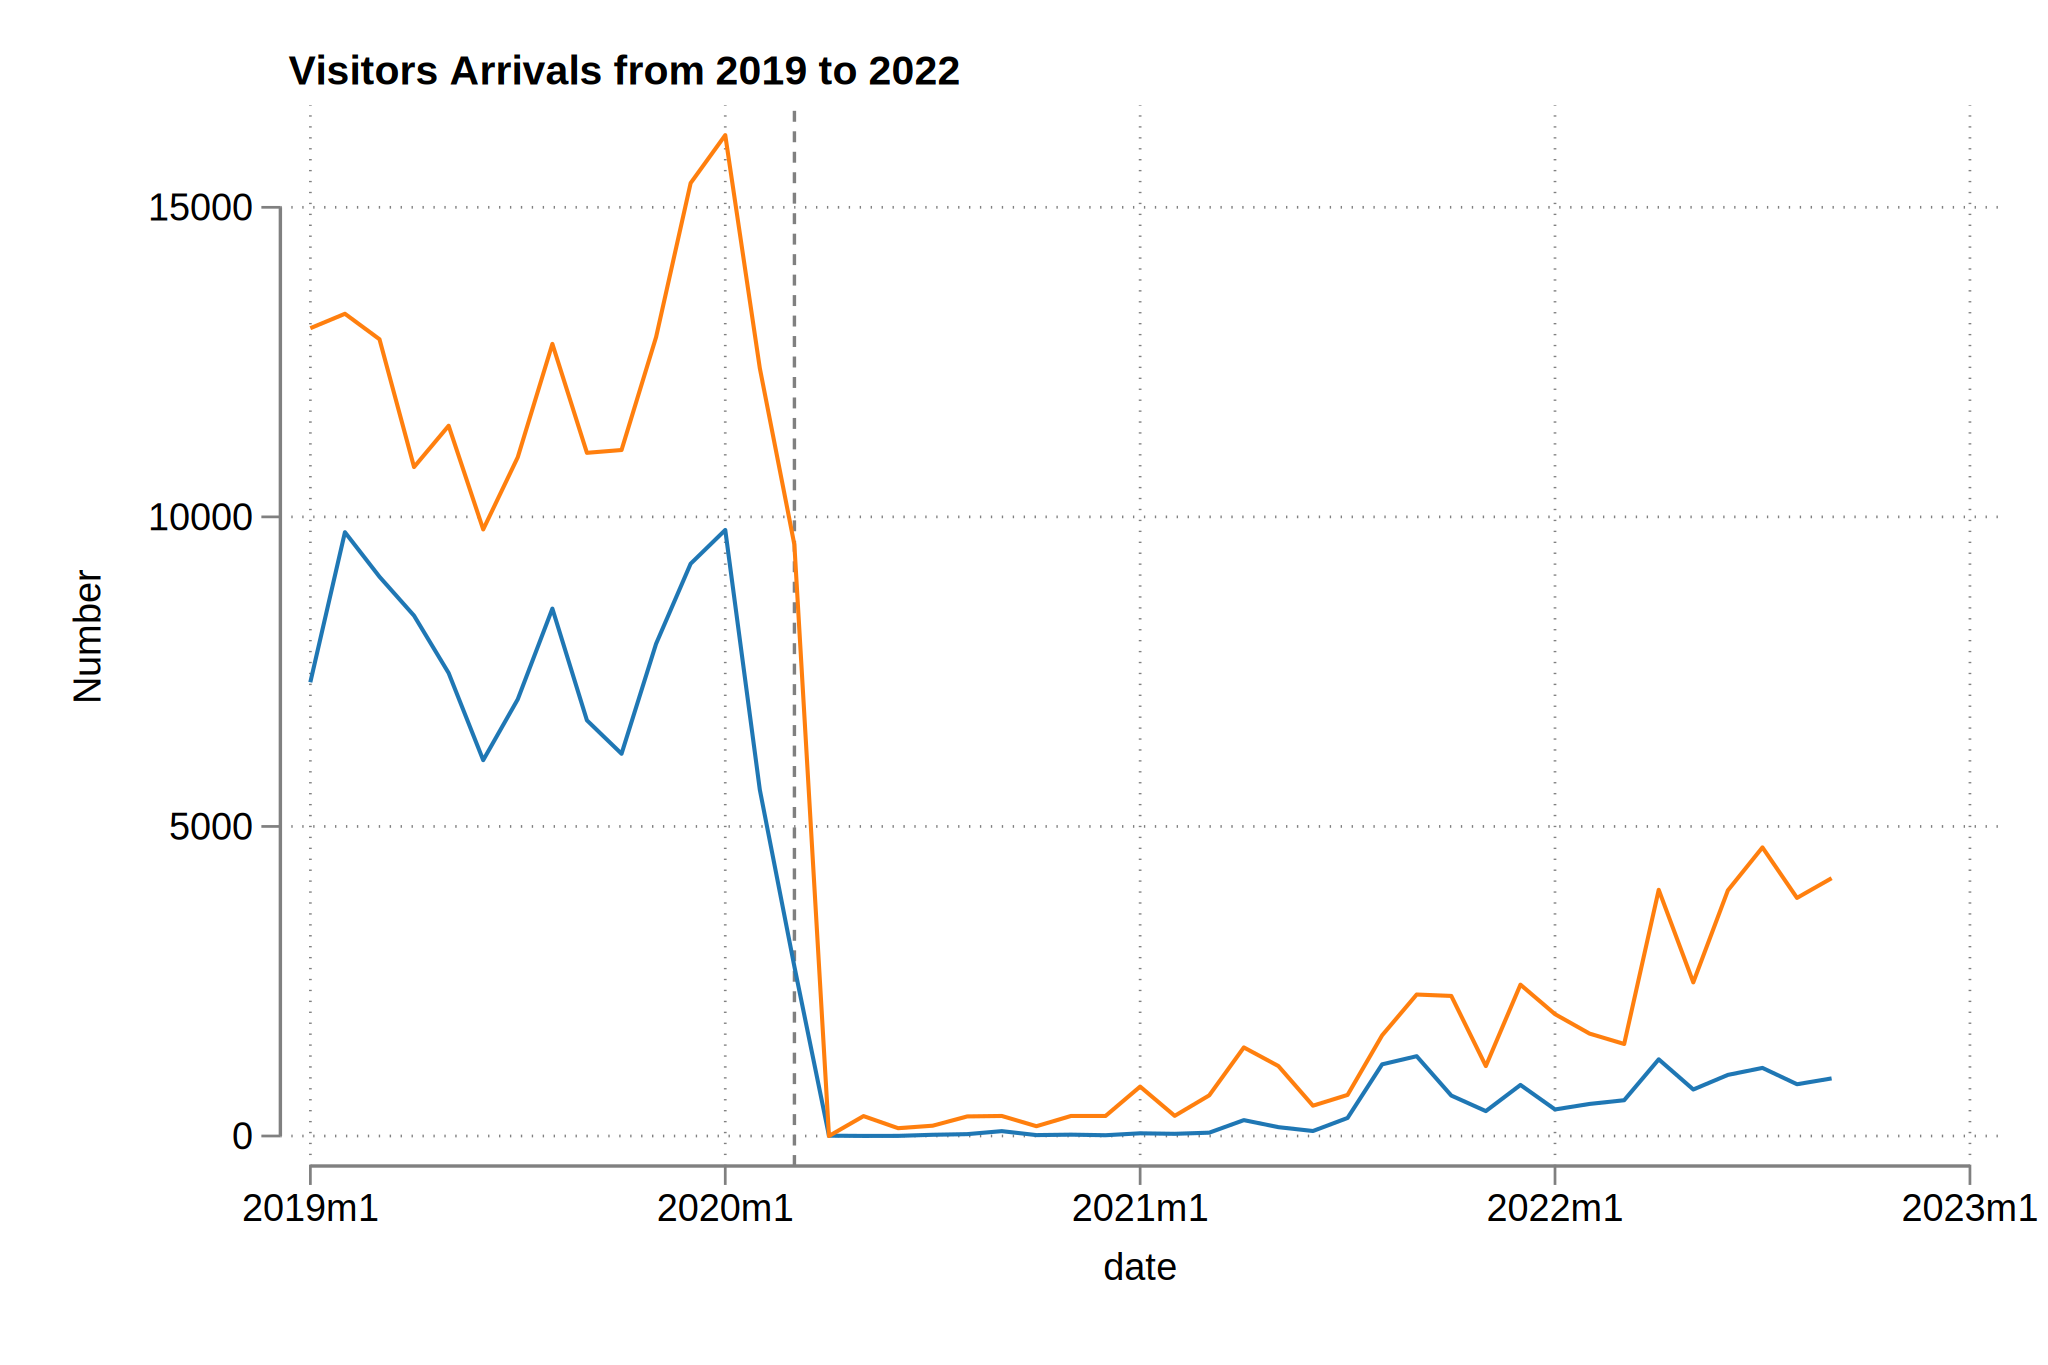

In [7]:
%%stata
tsline (total seats_arrivals_intl), tline(2020m3) mcolor(%60) mlwidth(0) ///
title("{bf}Visitors Arrivals from 2019 to 2022", pos(11) size(3)) ///
xtitle("date") ytitle("Number") ///
legend(off) ///
scheme(white_tableau)

In [8]:
%%stata
** employ dfuller to test stationarity
foreach x of varlist seats_arrivals_intl total{
	dfuller `x'
}


. ** employ dfuller to test stationarity
. foreach x of varlist seats_arrivals_intl total{
  2.         dfuller `x'
  3. }

Dickey–Fuller test for unit root           Number of obs  = 44
Variable: seats_arrival~tl                 Number of lags =  0

H0: Random walk without drift, d = 0

                                       Dickey–Fuller
                   Test      -------- critical value ---------
              statistic           1%           5%          10%
--------------------------------------------------------------
 Z(t)            -1.663       -3.621       -2.947       -2.607
--------------------------------------------------------------
MacKinnon approximate p-value for Z(t) = 0.4505.

Dickey–Fuller test for unit root           Number of obs  = 44
Variable: total                            Number of lags =  0

H0: Random walk without drift, d = 0

                                       Dickey–Fuller
                   Test      -------- critical value ---------
           

In [9]:
%%stata
** differencing variables
foreach x of varlist seats_arrivals_intl total {
	gen diff_`x' = d.`x'
}


. ** differencing variables
. foreach x of varlist seats_arrivals_intl total {
  2.         gen diff_`x' = d.`x'
  3. }
(1 missing value generated)
(1 missing value generated)

. 


In [10]:
%%stata
** Optimal lag selection
varsoc diff_seats_arrivals_intl diff_total, maxlag(8)


. ** Optimal lag selection
. varsoc diff_seats_arrivals_intl diff_total, maxlag(8)

Lag-order selection criteria

   Sample: 2019m10 thru 2022m9                              Number of obs = 36
  +---------------------------------------------------------------------------+
  | Lag |    LL      LR      df    p     FPE       AIC      HQIC      SBIC    |
  |-----+---------------------------------------------------------------------|
  |   0 | -606.756                     1.7e+12   33.8198   33.8505   33.9077  |
  |   1 | -598.411   16.69    4  0.002 1.3e+12   33.5784   33.6705   33.8423  |
  |   2 | -580.129  36.564    4  0.000 6.0e+11   32.7849   32.9385   33.2248* |
  |   3 | -578.735  2.7871    4  0.594 6.9e+11   32.9297   33.1447   33.5455  |
  |   4 | -570.287  16.897    4  0.002 5.5e+11   32.6826   32.9589   33.4744  |
  |   5 |  -559.86  20.853*   4  0.000 3.9e+11*  32.3256*  32.6633*  33.2933  |
  |   6 | -556.695  6.3304    4  0.176 4.2e+11   32.3719   32.7711   33.5156  |
  |   

In [11]:
%%stata
** Vector Autogressive Models
var diff_total diff_seats_arrivals_intl, exog(stringency_index covid) dfk small


. ** Vector Autogressive Models
. var diff_total diff_seats_arrivals_intl, exog(stringency_index covid) dfk sma
> ll
note: covid omitted because of collinearity.

Vector autoregression

Sample: 2021m1 thru 2022m9                      Number of obs     =         21
Log likelihood =  -304.5915                     AIC               =   30.15157
FPE            =   4.40e+10                     HQIC              =   30.28111
Det(Sigma_ml)  =   1.36e+10                     SBIC              =   30.74844

Equation           Parms      RMSE     R-sq        F       P > F
----------------------------------------------------------------
diff_total            6     276.536   0.5346    3.44637   0.0285
diff_seats_arr~l      6     742.976   0.5293   3.373297   0.0306
----------------------------------------------------------------

------------------------------------------------------------------------------
             | Coefficient  Std. err.      t    P>|t|     [95% conf. interval]
------------


. irf create var1, step(12) set($folder/scripts/notebooks/tourism/modelling/pal
> au_irf) replace
(file /Users/czhang/Desktop/pacific-observatory/scripts/notebooks/tourism/model
> ling/palau_irf.irf now active)
(file /Users/czhang/Desktop/pacific-observatory/scripts/notebooks/tourism/model
> ling/palau_irf.irf updated)

. irf graph oirf, ///
> impulse(diff_seats_arrivals_intl) response(diff_total) ///
> yline(0,lcolor(black)) xlabel(0(3)12) byopts(yrescale) ///
> scheme(white_tableau)

. 


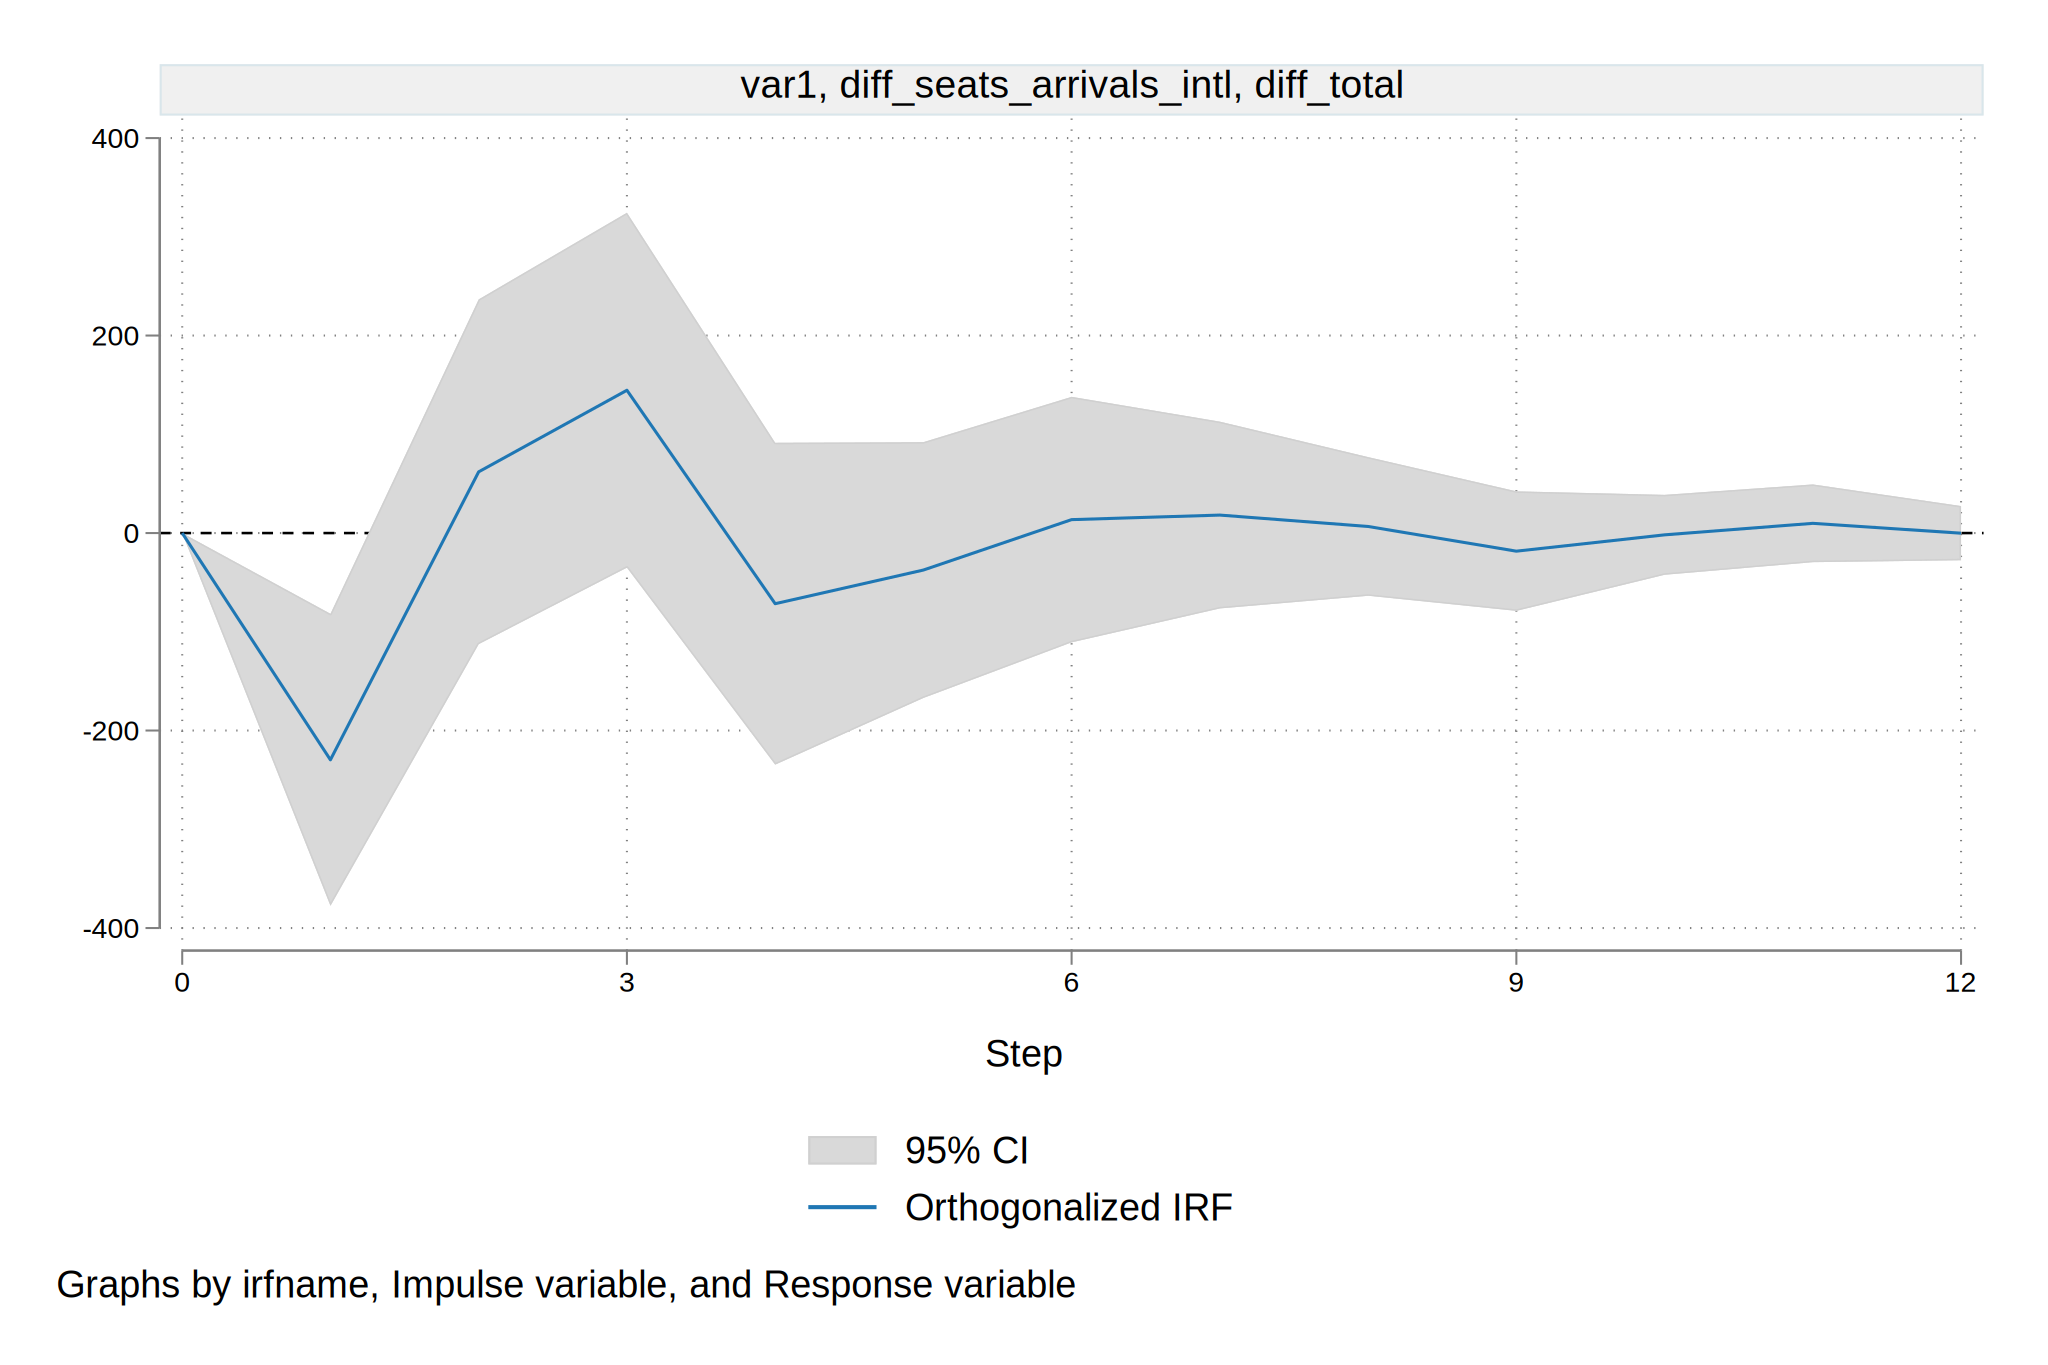

In [12]:
%%stata
irf create var1, step(12) set($folder/scripts/notebooks/tourism/modelling/palau_irf) replace
irf graph oirf, ///
impulse(diff_seats_arrivals_intl) response(diff_total) ///
yline(0,lcolor(black)) xlabel(0(3)12) byopts(yrescale) ///
scheme(white_tableau)

In [13]:
%%stata
** Robustness Check
varstable
predict error, residual


. ** Robustness Check
. varstable

   Eigenvalue stability condition
  +----------------------------------------+
  |        Eigenvalue        |   Modulus   |
  |--------------------------+-------------|
  |  .06269116 +  .7198751i  |     .7226   |
  |  .06269116 -  .7198751i  |     .7226   |
  |  -.4776104 +  .4730879i  |   .672253   |
  |  -.4776104 -  .4730879i  |   .672253   |
  +----------------------------------------+
   All the eigenvalues lie inside the unit circle.
   VAR satisfies stability condition.

. predict error, residual
(3 missing values generated)

. 



. tsline error, ///
> title("Residual Over Time", pos(11) size(3)) ///
> scheme(white_tableau)

. 


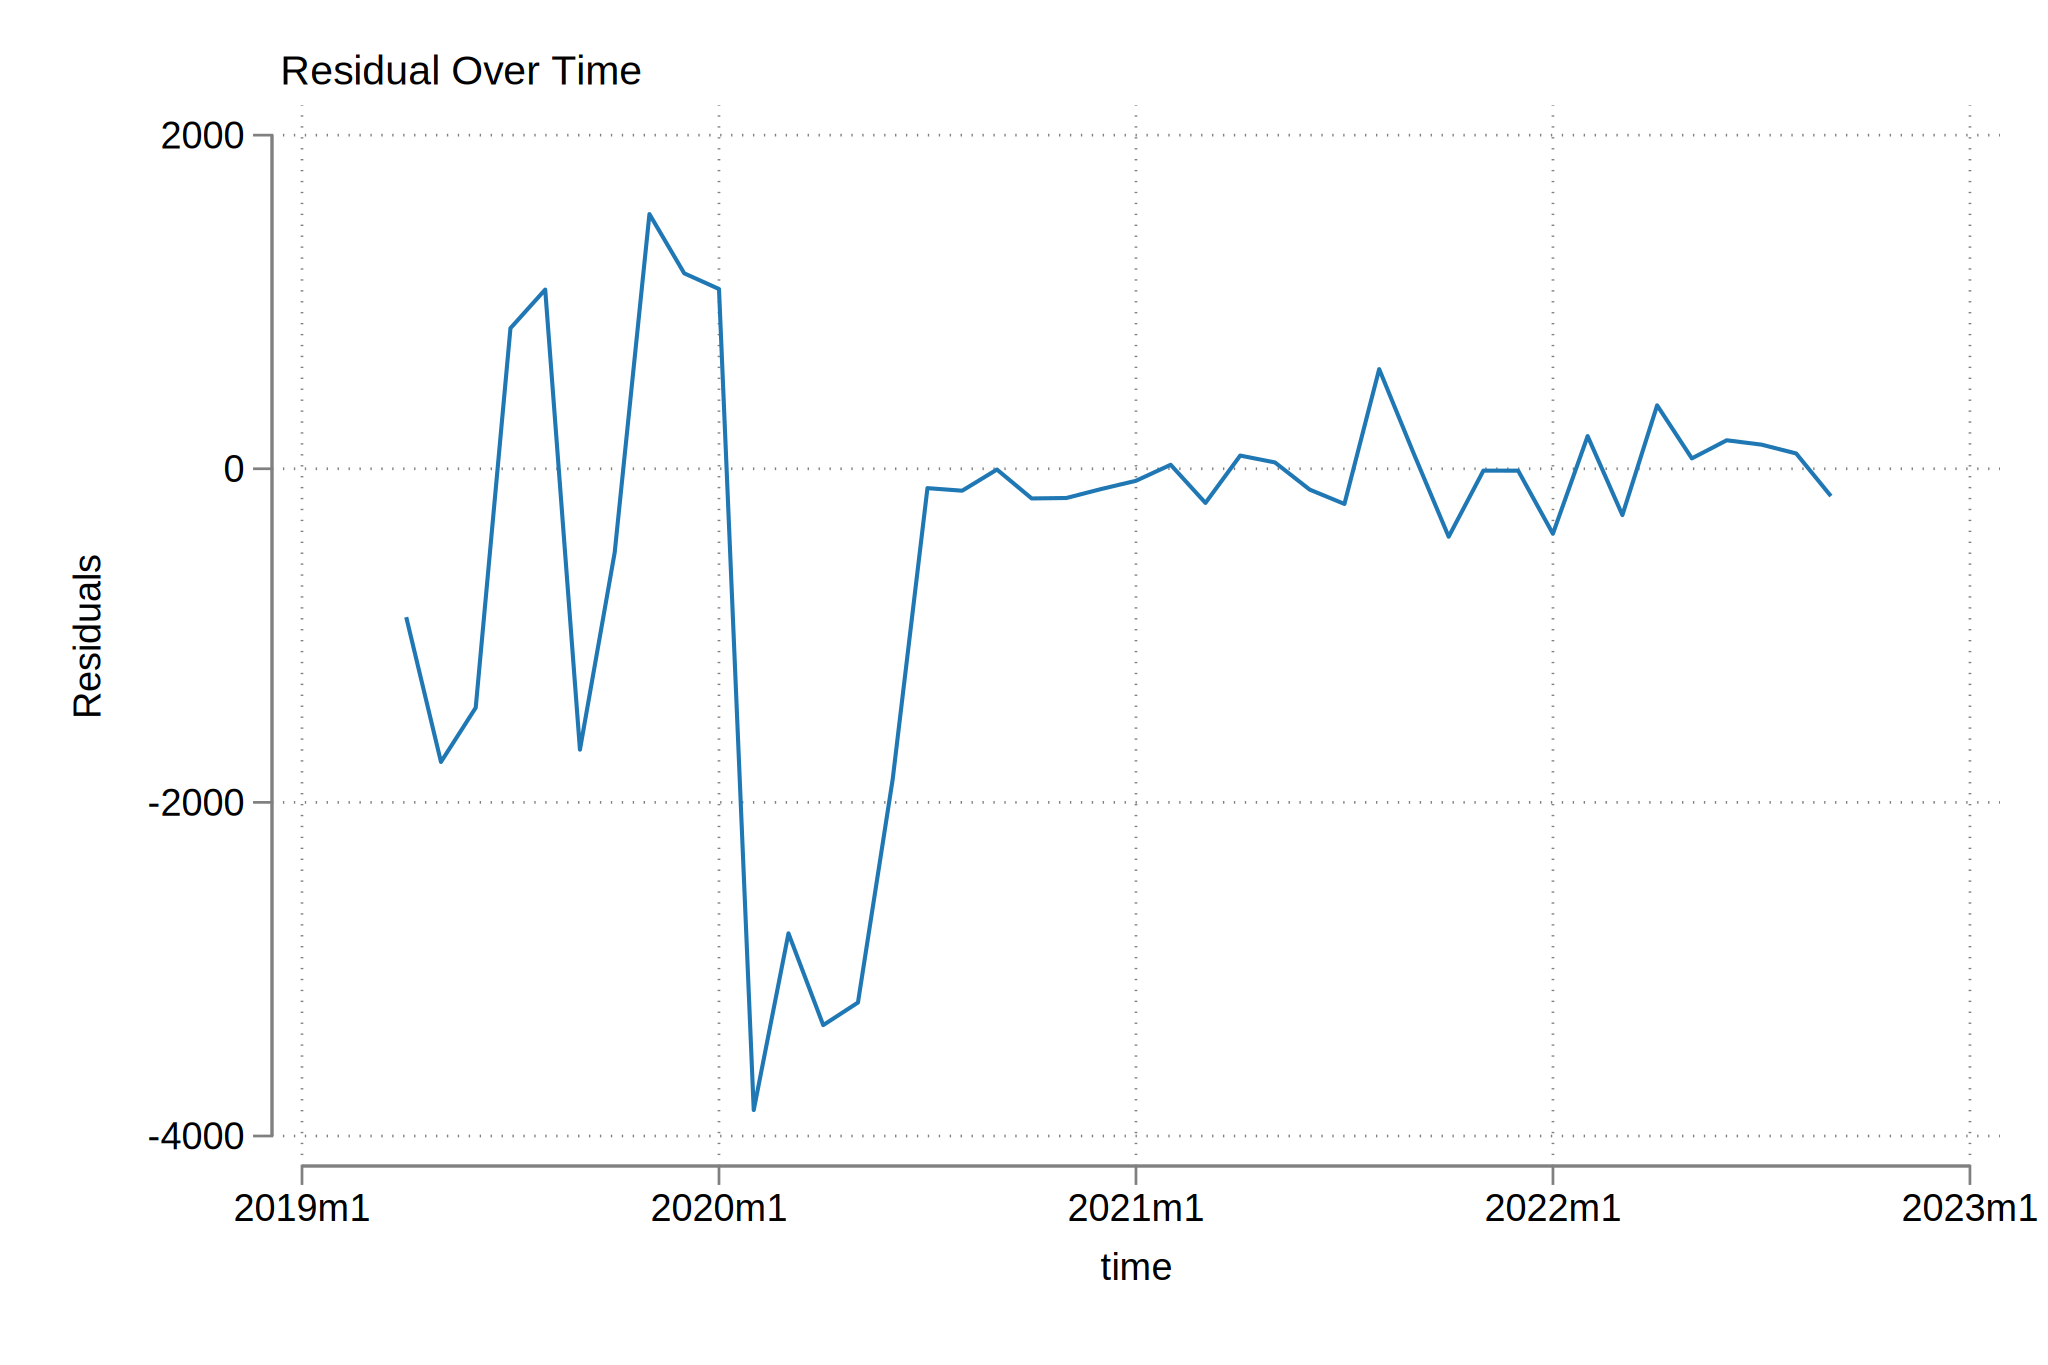

In [17]:
%%stata
tsline error, ///
title("Residual Over Time", pos(11) size(3)) ///
scheme(white_tableau)

In [19]:
%%stata
** check autocorrelation at lag
varlmar


   Lagrange-multiplier test
  +--------------------------------------+
  | lag  |      chi2    df   Prob > chi2 |
  |------+-------------------------------|
  |   1  |    9.6931     4     0.04593   |
  |   2  |    6.2212     4     0.18323   |
  +--------------------------------------+
   H0: no autocorrelation at lag order
